# **Statistical Learning Assignment - 4**

**Team Members**:

Prashanth Aripirala(PA500)

Rohit Macherla(RM1667)

Vishal Reddy Mekala(VM574)

#### **Contribution** -
This project is a collective effort from everyone in the team, but each one of us focused on one part primary aspect of this project as mentioned below:

**Rohit Macherla** : Neural Network Architecture definition,training and evaluation.

**Prashanth Aripirala** : Conformal Score calculation and prediction sets generation.

**Vishal Reddy Mekala** : Variable exclusion test using Hypothesis Testing for Feature selection.

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
warnings.filterwarnings('ignore')

### Import Data and pre-process

In [2]:
spotify = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv')
spotify = spotify.dropna()

In [3]:
X = spotify[['track_popularity','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]
y = spotify['playlist_genre']
text_data = spotify['playlist_name']

In [4]:
#TF-IDF Vectorization for text column(playlist_name)
vectorizer = TfidfVectorizer()
text_features = vectorizer.fit_transform(text_data).toarray()
text_tensor = torch.tensor(text_features, dtype=torch.float32)

In [5]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
one_hot_encoder = OneHotEncoder(sparse=False)
y_encoded = y_encoded.reshape(len(y_encoded), 1)
y_onehot = one_hot_encoder.fit_transform(y_encoded)

scaler = StandardScaler()
X = scaler.fit_transform(X)


X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y_onehot, dtype=torch.float)

X = torch.cat([text_tensor, X], dim=1) #Combining text and numerical features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# splitting train data into d1 and d2 for conformal prediction

X_train1 = X_train[:20000]
y_train1 = y_train[:20000]

X_train2 = X_train[20000:]
y_train2 = y_train[20000:]

# creating inputs for training the neural networks
train_data1 = TensorDataset(X_train1, y_train1)
train_loader1 = DataLoader(dataset=train_data1, batch_size=32, shuffle=True)

### **Neural Network Architecture**

We've constructed a neural network named SpotifyNet for a specific task, likely related to music classification on Spotify. The network has three hidden layers with 256 units in each followed by batch normalization to improve training stability and ReLU activation functions to introduce non-linearity. The final layer utilizes softmax activation to produce probabilities for multiple classes.

When we feed input data through this network using the forward method, it generates predictions in the form of probabilities for each class. To train the network, we've defined a loss function (loss_fn) based on cross entropy and used Adam with weight decay as the optimizer.

In [7]:
class SpotifyNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SpotifyNet, self).__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size[0]),
            nn.BatchNorm1d(hidden_size[0]),
            nn.ReLU(),
            nn.Linear(hidden_size[0], hidden_size[1]),
            nn.BatchNorm1d(hidden_size[1]),
            nn.ReLU(),
            nn.Linear(hidden_size[1], hidden_size[2]),
            nn.BatchNorm1d(hidden_size[2]),
            nn.ReLU(),
            nn.Linear(hidden_size[2], output_size),
            nn.Softmax()
        )

    def forward(self, x):
        prob = self.layers(x)
        return prob

    def loss_fn(self, y, y_pred):
        loss = F.cross_entropy(y_pred, y)
        return loss

In [8]:
# Instantiate the model

input_size = X_train1.shape[1]
output_size = len(spotify['playlist_genre'].unique())
hidden_size = [256, 256, 256]
model = SpotifyNet(input_size, hidden_size, output_size)

In [9]:
lr = 0.0001
epochs = 50

optimizer = optim.AdamW(model.parameters(), lr=lr)

model.train()
training_loss = []
for epoch in range(epochs):

    for x_batch, y_batch in train_loader1:
        y_pred = model(x_batch)

        loss = model.loss_fn(y_batch, y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    training_loss.append(loss.item())

    if epoch % 10 == 0:
        print('epoch: ', epoch, 'loss:', f"{loss.item():.3}")

epoch:  0 loss: 1.08
epoch:  10 loss: 1.08
epoch:  20 loss: 1.05
epoch:  30 loss: 1.04
epoch:  40 loss: 1.07


In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
torch.save(model.state_dict(), '/content/drive/MyDrive/spotify-model-final.h5')

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

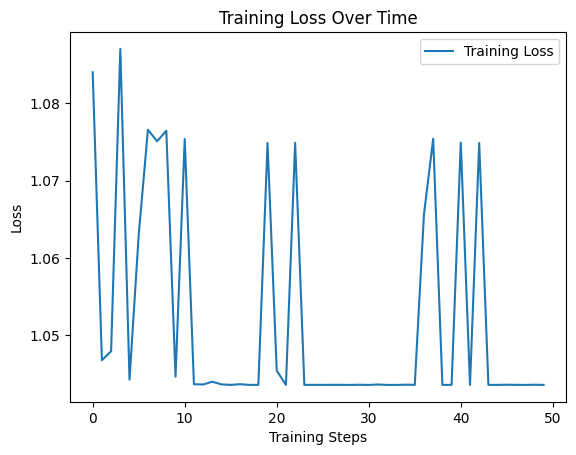

In [13]:
# plotting the train loss
plt.plot(training_loss, label='Training Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

In [14]:
# torch.save(model.state_dict(), 'spotify-model.h5')

In [15]:
model.eval()
with torch.no_grad():
    y_pred = model(X_test)

_, predicted_labels = torch.max(y_pred, 1)

predicted_labels = predicted_labels.numpy()
y_true = np.argmax(y_test.numpy(), axis=1)

accuracy = np.mean(predicted_labels == y_true)
print(f'Accuracy: {accuracy * 100:.2f}%')

from sklearn.metrics import classification_report
print('\nClassification Report:')
print(classification_report(y_true, predicted_labels))

Accuracy: 99.10%

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1229
           1       0.99      1.00      1.00       983
           2       0.98      0.99      0.98      1079
           3       0.98      0.97      0.97      1075
           4       1.00      1.00      1.00      1160
           5       1.00      1.00      1.00      1040

    accuracy                           0.99      6566
   macro avg       0.99      0.99      0.99      6566
weighted avg       0.99      0.99      0.99      6566



In [16]:
genres_to_predict = spotify['playlist_genre'].unique()

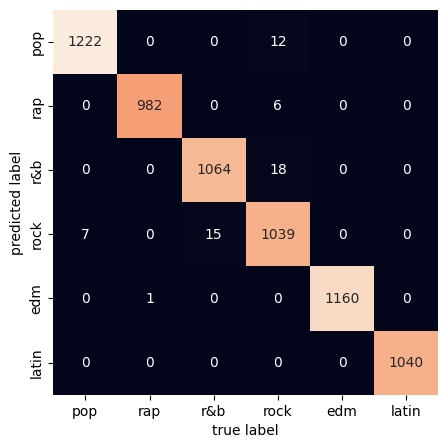

In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_true, predicted_labels)

plt.figure(figsize=(5,5))
sns.heatmap(conf_mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=set(genres_to_predict), yticklabels=set(genres_to_predict))
plt.xlabel('true label')
plt.ylabel('predicted label');

## **Conformal Prediction**

### **Logic for ComputeScore Function**

We first compute conformity scores and then subtract it from 1 to get a non-conformity score.

We initialize the score with zero. For the true class label we add the softmax probability to the score and negative of softmax probabilities for the remaining class labels. We take mean of the score to normalize it such that correct prediction have less non-conformity score and incorrect ones have higher scores


In [18]:
def computeProbability(sequence, probs):
    return(np.prod([probs[i] if sequence[i] == 1 else 1 - probs[i] for i in range(len(sequence))]))

def computeScore(my_outcome, probs):
    non_conformity_score = 0
    for i in range(len(my_outcome)):
        if my_outcome[i] == 1:
            non_conformity_score += probs[i]
        else:
            non_conformity_score += -probs[i]
    return 1-(non_conformity_score / len(probs))

def computeConformalSet(probs, scores, alpha):

    threshold = np.quantile(scores, (1 - alpha)*(n+1)/n)

    all_outcomes = list(itertools.product([0,1], repeat=len(probs)))
    sorted_outcomes = sorted(all_outcomes, key=lambda x: computeProbability(x, probs), reverse=True)

    sorted_probs = [computeProbability(outcome, probs) for outcome in sorted_outcomes]
    cumulative_probs = np.cumsum(sorted_probs)

    conformal_ix = np.where(cumulative_probs > threshold)[0][0]
    conformal_prediction_set = sorted_outcomes[:conformal_ix+1]


    return(conformal_prediction_set)

def confGenreSet(conf_set, genres_to_predict):

    confsets = [[genres_to_predict[i] for i in range(len(conf_set[k]))
        if conf_set[k][i] == 1] for k in range(len(conf_set))]

    confsets = [item for item in confsets if len(item)>0]
    return confsets

In [19]:
#Generating Prediction for holdout data D2
model.eval()
with torch.no_grad():
    y_pred = model(X_train2)

In [20]:
#Calculating Non-conformity scores using generated predictions and true genres
scores = np.zeros(len(y_train2))
for i in range(len(y_train2)):
    scores[i] = computeScore(y_train2[i], y_pred[i])

In [21]:
#Calculating the Adjusted threshold based on the distribution of scores
alpha = 0.2
n = len(scores)
print("Adjusted threshold: ", np.quantile(scores, (1 - alpha)*(n+1)/n))

Adjusted threshold:  0.8333334922790527


In [64]:
#Calculating the coverage percentage on holdout data D2
import itertools

correct_covered_count=0
for i in range(len(y_train2)):
    conformal_set = computeConformalSet(y_pred[i], scores, alpha)
    conf_genres = confGenreSet(conformal_set, genres_to_predict)
    unique_genres_set = set(genre for sublist in conf_genres for genre in sublist)
    true_label = genres_to_predict[y_train2[i].argmax()]

    if true_label in unique_genres_set:
        correct_covered_count += 1

percentage_correct_covered = (correct_covered_count / len(y_train2)) * 100
print(f"Percentage of times true value is covered: {percentage_correct_covered:.2f}%")

Percentage of times true value is covered: 98.85%


In [67]:
# Generating Conformal predictions on a random data point.
conformal_set = computeConformalSet(y_pred[441], scores, alpha)

print("Conformal Prediction Set:")
conf_genres = confGenreSet(conformal_set, genres_to_predict)

print(conf_genres)
print(genres_to_predict[y_test[441].argmax()])

Conformal Prediction Set:
[['latin'], ['pop', 'latin']]
pop


### **Hypothesis Testing - Variable Exclusion Test**

We opted for this technique to check significance of adding one particular variable to the model in predicting conditional expectation of Y(playlist_genre). The same test can be done for all other variables or combination of different variables. For illustration, we perform the test on one variable(track_popularity).


In [69]:
spotify = pd.read_csv('https://raw.githubusercontent.com/rfordatascience/tidytuesday/master/data/2020/2020-01-21/spotify_songs.csv')
spotify = spotify.dropna()
spotify.reset_index(drop=True)

,track_id,track_name,track_artist,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,6f807x0ima9a1j3VPbc7VN,I Don't Care (with Justin Bieber) - Loud Luxur...,Ed Sheeran,66,2oCs0DGTsRO98Gh5ZSl2Cx,I Don't Care (with Justin Bieber) [Loud Luxury...,2019-06-14,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,6,-2.634,1,0.0583,0.102000,0.000000,0.0653,0.5180,122.036,194754
1,0r7CVbZTWZgbTCYdfa2P31,Memories - Dillon Francis Remix,Maroon 5,67,63rPSO264uRjW1X5E6cWv6,Memories (Dillon Francis Remix),2019-12-13,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,11,-4.969,1,0.0373,0.072400,0.004210,0.3570,0.6930,99.972,162600
2,1z1Hg7Vb0AhHDiEmnDE79l,All the Time - Don Diablo Remix,Zara Larsson,70,1HoSmj2eLcsrR0vE9gThr4,All the Time (Don Diablo Remix),2019-07-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-3.432,0,0.0742,0.079400,0.000023,0.1100,0.6130,124.008,176616
3,75FpbthrwQmzHlBJLuGdC7,Call You Mine - Keanu Silva Remix,The Chainsmokers,60,1nqYsOef1yKKuGOVchbsk6,Call You Mine - The Remixes,2019-07-19,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,7,-3.778,1,0.1020,0.028700,0.000009,0.2040,0.2770,121.956,169093
4,1e8PAfcKUYoKkxPhrHqw4x,Someone You Loved - Future Humans Remix,Lewis Capaldi,69,7m7vv9wlQ4i0LFuJiE2zsQ,Someone You Loved (Future Humans Remix),2019-03-05,Pop Remix,37i9dQZF1DXcZDD7cfEKhW,pop,...,1,-4.672,1,0.0359,0.080300,0.000000,0.0833,0.7250,123.976,189052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32823,7bxnKAamR3snQ1VGLuVfC1,City Of Lights - Official Radio Edit,Lush & Simon,42,2azRoBBWEEEYhqV6sb7JrT,City Of Lights (Vocal Mix),2014-04-28,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,2,-1.814,1,0.0936,0.076600,0.000000,0.0668,0.2100,128.170,204375
32824,5Aevni09Em4575077nkWHz,Closer - Sultan & Ned Shepard Remix,Tegan and Sara,20,6kD6KLxj7s8eCE3ABvAyf5,Closer Remixed,2013-03-08,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,0,-4.462,1,0.0420,0.001710,0.004270,0.3750,0.4000,128.041,353120
32825,7ImMqPP3Q1yfUHvsdn7wEo,Sweet Surrender - Radio Edit,Starkillers,14,0ltWNSY9JgxoIZO4VzuCa6,Sweet Surrender (Radio Edit),2014-04-21,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,6,-4.899,0,0.0481,0.108000,0.000001,0.1500,0.4360,127.989,210112
32826,2m69mhnfQ1Oq6lGtXuYhgX,Only For You - Maor Levi Remix,Mat Zo,15,1fGrOkHnHJcStl14zNx8Jy,Only For You (Remixes),2014-01-01,♥ EDM LOVE 2020,6jI1gFr6ANFtT8MmTvA2Ux,edm,...,2,-3.361,1,0.1090,0.007920,0.127000,0.3430,0.3080,128.008,367432


In [70]:
X = spotify[['track_popularity','danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']]
y = spotify['playlist_genre']

In [71]:
encoder = LabelEncoder()
y = encoder.fit_transform(y)

one_hot_encoder = OneHotEncoder(sparse=False)
y = y_encoded.reshape(len(y), 1)
y = one_hot_encoder.fit_transform(y)

# standard scaling X
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [72]:
ind = np.arange(0,X.shape[0])
np.random.shuffle(ind)
ind

array([ 3813, 11929, 14076, ..., 26575, 31225, 31768])

In [73]:
size = int(len(ind)*0.70)
ind_1 = ind[0:size]
ind_2 = ind[size:]

In [74]:
# For dataset D1
d1_X = X[ind_1]
d1_X

array([[ 1.14156686,  0.09063106,  0.10721939, ..., -0.71008931,
        -1.07387292, -0.56148581],
       [ 0.06070631,  0.16644631,  0.83685158, ...,  1.33582171,
         0.505752  ,  2.79838797],
       [ 0.02067444, -0.57102931,  0.19013214, ...,  0.67100786,
         0.56897863,  0.44682729],
       ...,
       [ 1.46182184,  1.17272146, -0.58372018, ...,  0.12628941,
        -0.84769183, -0.2680985 ],
       [ 0.62115252, -1.08105917, -2.24750267, ..., -0.69722195,
        -1.92990421,  0.91567875],
       [ 1.62194932,  1.13825998, -1.36310002, ...,  0.98411374,
        -0.12945072,  0.47000747]])

In [75]:
# For dataset D1
d1_y = y[ind_1]
d1_y

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1.]])

In [76]:
# For dataset D2
d2_X = X[ind_2]
d2_X

array([[ 0.58112065, -1.17065902, -1.32993492, ..., -1.75234587,
        -1.57325548,  0.83263452],
       [-0.29958054, -0.12992239,  0.39465025, ..., -0.28975539,
        -0.10577326, -0.4914773 ],
       [ 1.58191745, -0.70887522,  0.05747174, ...,  0.07481995,
        -0.1227229 , -1.14665603],
       ...,
       [-1.6606642 , -0.06789174, -0.4234222 , ..., -0.57283742,
        -1.25812594,  0.7081768 ],
       [-1.6606642 ,  0.10441565,  0.32832005, ..., -1.50786594,
         0.04149534, -0.33374506],
       [-1.70069607, -0.37115274,  1.39513075, ...,  1.96203347,
         0.26299298, -0.77321602]])

In [77]:
# For dataset D2
d2_y = y[ind_2]
d2_y

array([[0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]])

In [34]:
# Let's perform the test for the first variable - track_popularity

- The objective of the hypothesis is to check whether adding the variable track_popularity to the model is adding significance.
- H0 : E[ Y | X_j ] = E[ Y|Xj , X_j]
- H1 : E[ Y | X_j ] != E[ Y|Xj , X_j ]

- A lower p-value indicates that null hypothesis can be rejected and that the variable is considered to be important and therefore has an impact on the conditional expectation of Y.

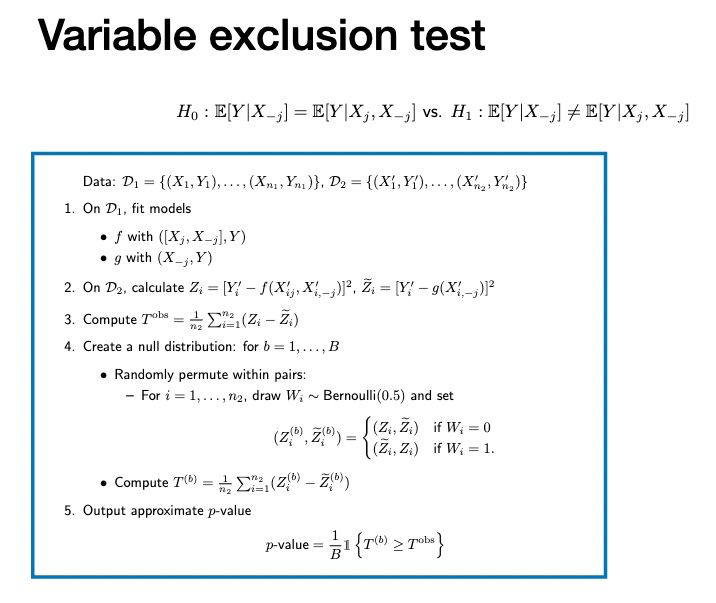

In [78]:
# Preparing data for model f using all variables
model1_d1 = d1_X[:,:]
model1_d1

array([[ 1.14156686,  0.09063106,  0.10721939, ..., -0.71008931,
        -1.07387292, -0.56148581],
       [ 0.06070631,  0.16644631,  0.83685158, ...,  1.33582171,
         0.505752  ,  2.79838797],
       [ 0.02067444, -0.57102931,  0.19013214, ...,  0.67100786,
         0.56897863,  0.44682729],
       ...,
       [ 1.46182184,  1.17272146, -0.58372018, ...,  0.12628941,
        -0.84769183, -0.2680985 ],
       [ 0.62115252, -1.08105917, -2.24750267, ..., -0.69722195,
        -1.92990421,  0.91567875],
       [ 1.62194932,  1.13825998, -1.36310002, ...,  0.98411374,
        -0.12945072,  0.47000747]])

In [79]:
# Preparing data for model g without the track_popularity column
model2_d1 = d1_X[:,1:]
model2_d1

array([[ 0.09063106,  0.10721939, -1.21111132, ..., -0.71008931,
        -1.07387292, -0.56148581],
       [ 0.16644631,  0.83685158,  1.55780825, ...,  1.33582171,
         0.505752  ,  2.79838797],
       [-0.57102931,  0.19013214, -1.48800328, ...,  0.67100786,
         0.56897863,  0.44682729],
       ...,
       [ 1.17272146, -0.58372018,  0.17334847, ...,  0.12628941,
        -0.84769183, -0.2680985 ],
       [-1.08105917, -2.24750267, -0.10354349, ..., -0.69722195,
        -1.92990421,  0.91567875],
       [ 1.13825998, -1.36310002, -1.21111132, ...,  0.98411374,
        -0.12945072,  0.47000747]])

In [80]:
# Converting into tensors for model training
model1_d1 = torch.tensor(model1_d1, dtype=torch.float32)
d1_y = torch.tensor(d1_y, dtype=torch.float)

In [81]:
# Converting into tensors for model training
model2_d1 = torch.tensor(model2_d1, dtype=torch.float32)
d1_y = torch.tensor(d1_y, dtype=torch.float)

**Step 1**

In [82]:
# Training model f or 1

# Convert data to DataLoader
train_dataset = TensorDataset(model1_d1, d1_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Instantiate the model
input_size = model1_d1.shape[1]
hidden_size = [128,128,128]
output_size = len(spotify['playlist_genre'].unique())
model1 = SpotifyNet(input_size, hidden_size, output_size)

lr = 0.0001
epochs = 50

optimizer = optim.AdamW(model1.parameters(), lr=lr)

model1.train()
for epoch in range(epochs):

    for x_batch, y_batch in train_loader:
        y_pred = model1(x_batch)

        loss = model1.loss_fn(y_batch, y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print('epoch: ', epoch, 'loss:', f"{loss.item():.3}")

epoch:  0 loss: 1.52
epoch:  10 loss: 1.69
epoch:  20 loss: 1.71
epoch:  30 loss: 1.76
epoch:  40 loss: 1.72


In [83]:
# Training model g or 2

# Convert data to DataLoader
train_dataset = TensorDataset(model2_d1, d1_y)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Instantiate the model
input_size = model2_d1.shape[1]
hidden_size = [128,128,128]
output_size = len(spotify['playlist_genre'].unique())
model2 = SpotifyNet(input_size, hidden_size, output_size)


lr = 0.0001
epochs = 50

optimizer = optim.AdamW(model2.parameters(), lr=lr)

model2.train()
for epoch in range(epochs):

    for x_batch, y_batch in train_loader:
        y_pred = model2(x_batch)

        loss = model2.loss_fn(y_batch, y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print('epoch: ', epoch, 'loss:', f"{loss.item():.3}")

epoch:  0 loss: 1.63
epoch:  10 loss: 1.37
epoch:  20 loss: 1.83
epoch:  30 loss: 1.5
epoch:  40 loss: 1.13


In [84]:
## Preparing D2 for calculating zi and zi_
model1_d2 = d2_X[:,:]
model2_d2 = d2_X[:,1:]

model1_d2 = torch.tensor(model1_d2, dtype=torch.float32)
model2_d2 = torch.tensor(model2_d2, dtype=torch.float32)

d2_y = torch.tensor(d2_y, dtype=torch.float)

Step 2

In [85]:
output1_d2 = model1(model1_d2)

In [86]:
output2_d2 = model2(model2_d2)

In [87]:
zi = []
for i in range(d2_y.shape[0]):
    zi.append(F.cross_entropy(output1_d2[i],d2_y[i]).item())

In [88]:
zi_ = []
for i in range(d2_y.shape[0]):
    zi_.append(F.cross_entropy(output2_d2[i],d2_y[i]).item())

In [89]:
zi = np.array(zi)

In [90]:
zi_ = np.array(zi_)

**Step 3**

In [91]:
tstat_obs = (zi - zi_).mean()
tstat_obs

-0.007289410835716952

In [92]:
tstat_calc = []

for B in range(5000): # Can further be increased to have a higher power for the hypothesis test
    diff = []
    for i in range(len(zi)):
        if np.random.randint(0,2) == 0:
            diff.append(zi[i] - zi_[i])
        else:
            diff.append(zi_[i] - zi[i])

    tstat = np.array(diff).mean()
    tstat_calc.append(tstat)

In [93]:
p_value = sum([1 for t in tstat_calc if t <= tstat_obs]) / 5000

print(f"Observed test statistic: {tstat_obs:.4f}")
print(f"P-Value: {p_value:.4f}")

Observed test statistic: -0.0073
P-Value: 0.0010


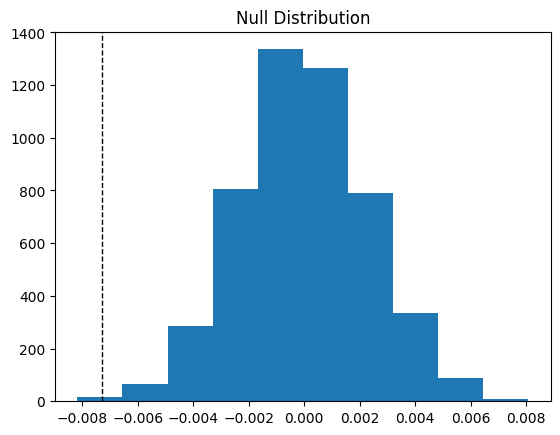

In [94]:
plt.hist(tstat_calc)
plt.axvline(tstat_obs, color='k', linestyle='dashed', linewidth=1)
plt.title('Null Distribution')
plt.show()

The p-value is super low(0.0010) which is less than alpha(0.05) and with B = 5000, we can reject the null hypothesis and conclude that the variable 'track_popularity' does have statistical significance on the conditional expectation of Y.